In [43]:
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, distance
import cv2
import numpy as np
import matplotlib.cm as cm
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.lines as mlines
import string
import matplotlib.patches as patches

In [44]:
column_names = ['frame','vehicle_id','vehicle_type','a','b','c','X1','Y1','X2','Y2',]
# df = pd.read_csv("C:\\Users\\ancha\\Box\\QC-5900\\Data\\project2\\16393238\\segments\\16393238-cam_1-2-north_west-20231109_0000-010_1699916237331_out\\16393238-cam_1-2-north_west-20231109_0000-010_1699916237331.txt", sep=' ', header=None, usecols = [0,1,2,3,4,5,6,7,8,9], names=column_names)
df = pd.read_csv("C:\\Users\\ancha\\Box\\QC-5900\\Data\\project2\\16393239\\segments\\16393239-cam_1-3-south_east-20231109_0000-010_1699928799703_out\\16393239-cam_1-3-south_east-20231109_0000-010_1699928799703.txt", sep=' ', header=None, usecols = [0,1,2,3,4,5,6,7,8,9], names=column_names)
# df = pd.read_csv("C:\\Users\\ancha\\Box\\QC-5900\\Data\\project2\\16393240\\segments\\16393240-cam_1-2-south_west-20231109_0000-010_1699922657350_out\\16393240-cam_1-2-south_west-20231109_0000-010_1699922657350.txt", sep=' ', header=None, usecols = [0,1,2,3,4,5,6,7,8,9], names=column_names)
# df = pd.read_csv("C:\\Users\\ancha\\Box\\QC-5900\\Data\\project2\\16393241\\segments\\16393241-cam_1-2-south_west-20231109_0000-010_1699916981923_out\\16393241-cam_1-2-south_west-20231109_0000-010_1699916981923.txt", sep=' ', header=None, usecols = [0,1,2,3,4,5,6,7,8,9], names=column_names)
# df = pd.read_csv("C:\\Users\\ancha\\Box\\QC-5900\\Data\\project2\\16393242\\segments\\16393242-cam_1-4-south_west-20231109_0000-010_1700066770343_out\\16393242-cam_1-4-south_west-20231109_0000-010_1700066770343.txt", sep=' ', header=None, usecols = [0,1,2,3,4,5,6,7,8,9], names=column_names)

df['Center_X'] = (df['X1']+df['X2']) / 2
df['Center_Y'] = (df['Y1']+df['Y2']) / 2

df = df[['frame','vehicle_id','vehicle_type','Center_X','Center_Y']]

In [45]:
print(df.shape)
df_unique = df.nunique()
df_unique

(195405, 5)


frame           35787
vehicle_id       2338
vehicle_type       11
Center_X         1275
Center_Y          735
dtype: int64

In [46]:
# image_path = "C:\\Users\\ancha\\Box\\QC-5900\\Data\\project2\\16393238\\16393238-cam_1-2-north_west-20231109_0000_1699916237331_out\\16393238-cam_1-2-north_west-20231109_0000_1699916237331_frame.jpg"
image_path = "C:\\Users\\ancha\\Box\\QC-5900\\Data\\project2\\16393239\\16393239-cam_1-3-south_east-20231109_0000_1699928799703_out\\16393239-cam_1-3-south_east-20231109_0000_1699928799703_frame.jpg"
# image_path = "C:\\Users\\ancha\\Box\\QC-5900\\Data\\project2\\16393240\\segments\\16393240-cam_1-2-south_west-20231109_0000-010_1699922657350_out\\16393240-cam_1-2-south_west-20231109_0000-010_1699922657350_frame.jpg"
# image_path = "C:\\Users\\ancha\\Box\\QC-5900\\Data\\project2\\16393241\\segments\\16393241-cam_1-2-south_west-20231109_0000-010_1699916981923_out\\16393241-cam_1-2-south_west-20231109_0000-010_1699916981923_frame.jpg"
# image_path = "C:\\Users\\ancha\\Box\\QC-5900\\Data\\project2\\16393242\\segments\\16393242-cam_1-4-south_west-20231109_0000-010_1700066770343_out\\16393242-cam_1-4-south_west-20231109_0000-010_1700066770343_frame.jpg"


In [47]:
df_sorted = df.sort_values(by=['vehicle_id','frame']).reset_index(drop=True)
# df_sorted = df_sorted.groupby('vehicle_id').filter(lambda x: (len(x) >= 15))

# df_sorted = df_sorted.groupby('vehicle_id').filter(
#     lambda x: (abs(x['Center_X'].iloc[0] - x['Center_X'].iloc[-1]) > 100) |
#               (abs(x['Center_Y'].iloc[0] - x['Center_Y'].iloc[-1]) > 100)
# )

df_sorted = df_sorted.groupby('vehicle_id').filter(
    lambda x: np.sqrt((x['Center_X'].iloc[-1] - x['Center_X'].iloc[0])**2 +
                      (x['Center_Y'].iloc[-1] - x['Center_Y'].iloc[0])**2) > 100
)

# df_sorted.to_csv("../testfile.csv")
# for vehicle_id, group in df_sorted.groupby('vehicle_id'):
#     count = ((abs(group['dx']) < 0.5) & (abs(group['dy']) < 0.5)).sum()
#     print(f"Vehicle ID: {vehicle_id}, Count: {count}")
    

print(df_sorted)
# # Filter based on mean dx and dy values
# df_sorted = df_sorted.groupby('vehicle_id').filter(
#     lambda x: abs(x['dx'].mean()) > 0.5 and abs(x['dy'].mean()) > 0.5
# )
df_first_frame = df_sorted.groupby('vehicle_id').head(1).reset_index()
df_last_frame = df_sorted.groupby('vehicle_id').tail(1).reset_index()
df_combined = pd.concat([df_first_frame, df_last_frame]).sort_values(by='vehicle_id').reset_index()

        frame  vehicle_id       vehicle_type  Center_X  Center_Y
83          1           2  cl2_passenger_car     167.5     225.5
84          2           2  cl2_passenger_car     156.0     233.0
85          3           2  cl2_passenger_car     140.0     242.0
86          4           2  cl2_passenger_car     124.0     253.5
87          5           2  cl2_passenger_car     107.0     265.0
...       ...         ...                ...       ...       ...
195383  35995        2947  cl2_passenger_car     413.5     216.5
195384  35996        2947  cl2_passenger_car     417.5     208.0
195385  35997        2947  cl2_passenger_car     421.0     200.5
195386  35998        2947  cl2_passenger_car     424.5     195.0
195387  35999        2947  cl2_passenger_car     427.0     190.5

[174126 rows x 5 columns]


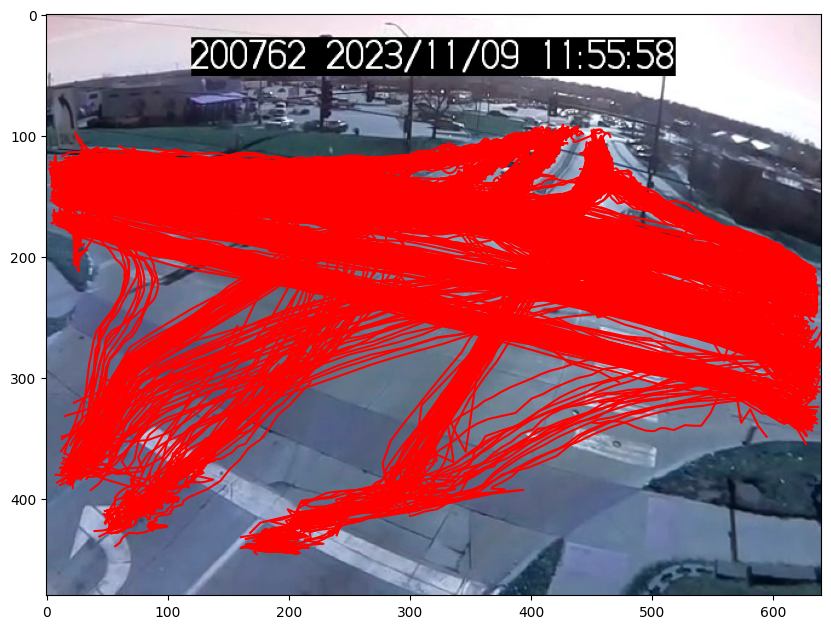

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cv2.imread(image_path))
# Group data by 'vehicle_id' and plot trajectory lines
for vehicle_id, group in df_sorted.groupby('vehicle_id'):
    max_x_travelled = abs(group['Center_X'].iloc[0] - group['Center_X'].iloc[-1])
    max_y_travelled = abs(group['Center_X'].iloc[0] - group['Center_X'].iloc[-1])
    # print(f"Vehicle ID: {vehicle_id}, max_x_travelled: {max_x_travelled}, max_y_travelled: {max_y_travelled}")
    # cluster_color = plt.get_cmap("viridis")(group['InCluster'].iloc[0]/df['InCluster'].max())
    ax.plot(group['Center_X'], group['Center_Y'], c='red')

In [49]:

# test = df_sorted.groupby('vehicle_id')[['dx', 'dy']].mean()
# moving_vehicle_ids = test[(test['dx'].abs()>0.2) & (test['dy'].abs()>0.2)].index
# # Filter df_sorted to keep only rows where vehicle_id is in moving_vehicle_ids
# df_sorted = df_sorted[df_sorted['vehicle_id'].isin(moving_vehicle_ids)]

# print(test[(test['dx'].abs()>0.2) & (test['dy'].abs()>0.2)])

# print(df_sorted[df_sorted['dx'] == 0])
print(df_sorted.shape)

(174126, 5)


In [50]:
df_sorted['dx'] = df_sorted.groupby('vehicle_id')['Center_X'].diff(500)
df_sorted['dy'] = df_sorted.groupby('vehicle_id')['Center_Y'].diff(500)

# # Filter based on count of dx and dy values
# parking = df_sorted.groupby('vehicle_id').filter(
#     lambda x: (((abs(x['dx']) < 50) & (abs(x['dy']) < 50)).sum() > 100)
# )
parking = df_sorted[(abs(df_sorted['dx'])<5)|(abs(df_sorted['dy'])<5)]

In [51]:
# fig, ax = plt.subplots(figsize=(10, 8))
# for vehicle_id, group in df_sorted.groupby('vehicle_id'):
#     ax.plot(group['Center_X'], group['Center_Y'], c = 'red')
#     ax.imshow(cv2.imread(image_path))

# fig, ax = plt.subplots(figsize=(10, 8))
# abc = df_sorted.merge(df_first_frame['vehicle_id'], on='vehicle_id', how='inner')
# for vehicle_id, group in df_first_frame.groupby('vehicle_id'):
#     ax.scatter(group['Center_X'], group['Center_Y'], c = 'red')
#     ax.imshow(cv2.imread(image_path))

# fig, ax = plt.subplots(figsize=(10, 8))
# abc = df_sorted.merge(df_last_frame['vehicle_id'], on='vehicle_id', how='inner')
# for vehicle_id, group in df_last_frame.groupby('vehicle_id'):
#     ax.scatter(group['Center_X'], group['Center_Y'], c = 'red')
#     ax.imshow(cv2.imread(image_path))


In [52]:
print(df_first_frame.shape)
print(df_last_frame.shape)

(1511, 6)
(1511, 6)


In [53]:

# test = df_sorted.groupby('vehicle_id')[['dx', 'dy']].mean()
# moving_vehicle_ids = test[(test['dx'].abs()>0.2) & (test['dy'].abs()>0.2)].index
# # Filter df_sorted to keep only rows where vehicle_id is in moving_vehicle_ids
# df_sorted = df_sorted[df_sorted['vehicle_id'].isin(moving_vehicle_ids)]

# print(test[(test['dx'].abs()>0.2) & (test['dy'].abs()>0.2)])

# print(df_sorted[df_sorted['dx'] == 0])
print(df_sorted.shape)

(174126, 7)


In [54]:
if(df_first_frame.shape[0] < 25):
    min_samples_val = 2
elif(df_first_frame.shape[0] < 100):
    min_samples_val = 5
else: min_samples_val = 20

In [55]:
# Assume df_first contains the first occurrence of each vehicle with 'x_center' and 'y_center'
# normalize X, Y coordinates
df_first_frame['Center_X_norm'] = (df_first_frame['Center_X'] - df_first_frame['Center_X'].mean()) / df_first_frame['Center_X'].std()
df_first_frame['Center_Y_norm'] = (df_first_frame['Center_Y'] - df_first_frame['Center_Y'].mean()) / df_first_frame['Center_Y'].std()

# Step 1: Extract the coordinates
X_first = df_first_frame[['Center_X_norm', 'Center_Y_norm']].values

# Step 2: Apply DBSCAN
# adjust epsilon ('eps') and min_samples based on data scale.
db = DBSCAN(eps=0.2, min_samples=min_samples_val)  # eps is the maximum distance between two samples for them to be considered neighbors

# Step 3: Fit the DBSCAN model
df_first_frame['Cluster'] = db.fit_predict(X_first)
df_outlier = df_first_frame[df_first_frame['Cluster'] == -1].reset_index(drop=True)
df_first = df_first_frame[df_first_frame['Cluster'] != -1].reset_index(drop=True)

# Compute centroid of each cluster
centroids = df_first.groupby('Cluster')[['Center_X', 'Center_Y']].mean().reset_index()

# Display centroids
# print(centroids)

# Display no. of vehicles in each cluster
print(df_first['Cluster'].value_counts())
print(df_outlier.shape)



Cluster
0    618
2    432
4    238
3     76
5     44
1     37
Name: count, dtype: int64
(66, 9)


In [56]:
unique_clusters = df_first['Cluster'].unique()
# Create a dynamic mapping from cluster ID to gate name
cluster_to_gate = {cluster_id: f'Gate {i+1}' for i, cluster_id in enumerate(unique_clusters)}
print(cluster_to_gate)
# Assign the corresponding gate names to the 'Gate' column
df_first['InGate'] = df_first['Cluster'].map(cluster_to_gate)

{np.int64(0): 'Gate 1', np.int64(1): 'Gate 2', np.int64(2): 'Gate 3', np.int64(3): 'Gate 4', np.int64(4): 'Gate 5', np.int64(5): 'Gate 6'}


0 : (619.45, 226) : 618
1 : (57.65, 419) : 37
2 : (19.77, 154) : 432
3 : (234.75, 133) : 76
4 : (409.55, 107) : 238
5 : (206.81, 428) : 44
[{'InClusterId': 0, 'InGate': 'Gate 1', 'Centroid': (619.45, 226), 'Boundary': (np.float64(505.0), np.float64(636.5), np.float64(178.5), np.float64(271.0))}, {'InClusterId': 1, 'InGate': 'Gate 2', 'Centroid': (57.65, 419), 'Boundary': (np.float64(39.5), np.float64(79.0), np.float64(398.5), np.float64(439.0))}, {'InClusterId': 2, 'InGate': 'Gate 3', 'Centroid': (19.77, 154), 'Boundary': (np.float64(3.5), np.float64(128.0), np.float64(110.0), np.float64(199.5))}, {'InClusterId': 3, 'InGate': 'Gate 4', 'Centroid': (234.75, 133), 'Boundary': (np.float64(140.0), np.float64(327.0), np.float64(116.5), np.float64(163.5))}, {'InClusterId': 4, 'InGate': 'Gate 5', 'Centroid': (409.55, 107), 'Boundary': (np.float64(349.0), np.float64(461.5), np.float64(93.5), np.float64(140.0))}, {'InClusterId': 5, 'InGate': 'Gate 6', 'Centroid': (206.81, 428), 'Boundary': (np.

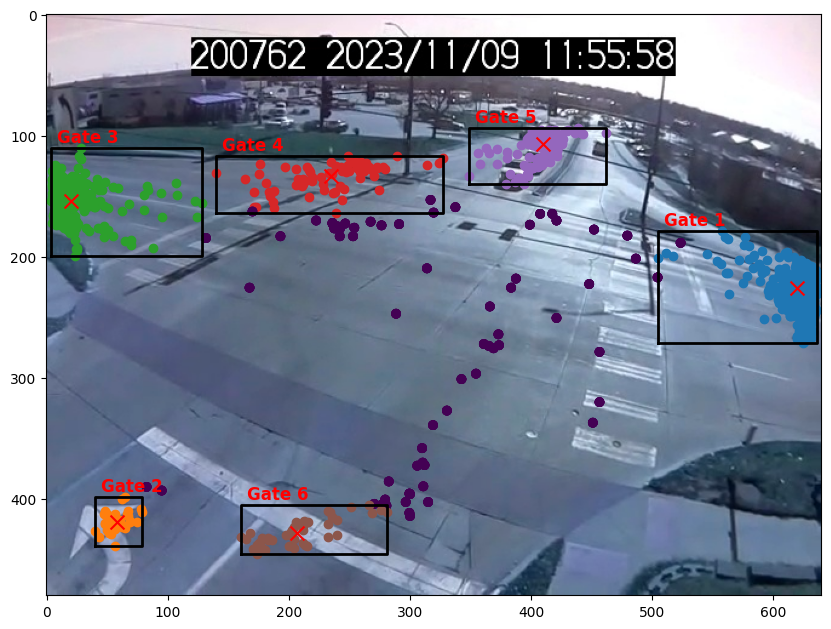

In [57]:
df_first_clusters = df_first.copy()

# Store updated clusters
updated_clusters = []
fig, ax = plt.subplots(figsize=(10, 8))
for cluster_id, group in df_first_clusters.groupby('Cluster'):
    # centroid = group[['Center_X','Center_Y']].mean().values
    centroid = (round(float(group['Center_X'].mean()),2), round(float(group['Center_Y'].mean())))
    cluster_count = len(group)
    print(cluster_id, ":", centroid, ":", cluster_count)


    # Find the extreme points
    x_min = group.loc[group['Center_X'].idxmin(), 'Center_X']  # Leftmost point
    x_max = group.loc[group['Center_X'].idxmax(), 'Center_X']  # Rightmost point
    y_min = group.loc[group['Center_Y'].idxmin(), 'Center_Y']  # Bottommost point
    y_max = group.loc[group['Center_Y'].idxmax(), 'Center_Y']  # Topmost point
    
    # # Identify outliers that are outside the cluster boundary
    # outliers_outside_boundary = df_outlier[
    #     (df_outlier['Center_X'] < x_min) | (df_outlier['Center_X'] > x_max) |
    #     (df_outlier['Center_Y'] < y_min) | (df_outlier['Center_Y'] > y_max)
    # ]
        
    # Define rectangle boundary
    rectangle_corners = np.array([
        [x_min, y_max],  # Top-left
        [x_max, y_max],  # Top-right
        [x_max, y_min],  # Bottom-right
        [x_min, y_min],  # Bottom-left
        [x_min, y_max]   # Close the rectangle
    ])

    # Plot the rectangle
    plt.plot(rectangle_corners[:, 0], rectangle_corners[:, 1], 'k-', linewidth=2)

    plt.scatter(df_outlier['Center_X'], df_outlier['Center_Y'], c = df_outlier['Cluster'])
    
    # Get InGate value using the cluster_id
    in_gate = cluster_to_gate.get(cluster_id, 'Unknown')  # Default to 'Unknown' if cluster_id not in the mapping

    # Append updated cluster data
    updated_clusters.append({
        'InClusterId': cluster_id,
        'InGate': in_gate,
        'Centroid': (centroid[0], centroid[1]),
        'Boundary': (x_min, x_max, y_min, y_max)
    })
    
    # Plot cluster points
    plt.scatter(group['Center_X'], group['Center_Y'], label=f'Cluster {cluster_id}')

    # Plot gate name near the cluster boundary (placing near top-right corner)
    plt.text(x_min + 5, y_min - 5, f'{in_gate}', fontsize=12, color='red', fontweight='bold')


    # Plot centroid
    plt.scatter(centroid[0], centroid[1], color='red', marker='x', s=100, label=f'Centroid {cluster_id}')

    ax.imshow(cv2.imread(image_path))
print(updated_clusters)
InGateClusters = pd.DataFrame(updated_clusters).sort_values('InClusterId').reset_index(drop=True)
print(InGateClusters)


In [58]:
# Assume df_last contains the last occurrence of each vehicle with 'x_center' and 'y_center'
# normalize X, Y coordinates
df_last_frame['Center_X_norm'] = (df_last_frame['Center_X'] - df_last_frame['Center_X'].mean()) / df_last_frame['Center_X'].std()
df_last_frame['Center_Y_norm'] = (df_last_frame['Center_Y'] - df_last_frame['Center_Y'].mean()) / df_last_frame['Center_Y'].std()

# Step 1: Extract the coordinates
X_last = df_last_frame[['Center_X_norm', 'Center_Y_norm']].values

# Step 2: Apply DBSCAN
# adjust epsilon ('eps') and min_samples based on data scale.
db = DBSCAN(eps=0.2, min_samples=min_samples_val)  # eps is the maximum distance between two samples for them to be considered neighbors

# Step 3: Fit the DBSCAN model
df_last_frame['Cluster'] = db.fit_predict(X_last)
df_outlier_last = df_last_frame[df_last_frame['Cluster'] == -1].reset_index(drop=True)
df_last = df_last_frame[df_last_frame['Cluster'] != -1].reset_index(drop=True)


# Compute centroid of each cluster
centroids = df_last.groupby('Cluster')[['Center_X', 'Center_Y']].mean().reset_index()

# # Display centroids
# print(centroids)

# Display no. of vehicles in each cluster
print(df_last['Cluster'].value_counts())
print(df_outlier_last.shape)





Cluster
1    617
3    421
2    313
0     78
4     35
Name: count, dtype: int64
(47, 9)


In [59]:
unique_clusters = df_last['Cluster'].unique()

# Generate labels A, B, C, ... for clusters
cluster_labels = list(string.ascii_uppercase)  # ['A', 'B', 'C', ..., 'Z']

# Ensure we don't exceed available labels
if len(unique_clusters) > len(cluster_labels):
    raise ValueError("Too many clusters, not enough labels!")

# Assign gate names using letters instead of numbers
cluster_to_gate = {cluster_id: f'Gate {cluster_labels[i]}' for i, cluster_id in enumerate(unique_clusters)}

print(cluster_to_gate)

# Assign the corresponding gate names to the 'Gate' column
df_last['OutGate'] = df_last['Cluster'].map(cluster_to_gate)

{np.int64(0): 'Gate A', np.int64(1): 'Gate B', np.int64(2): 'Gate C', np.int64(3): 'Gate D', np.int64(4): 'Gate E'}


0 : (21.18, 372) : 78
0 Gate A
1 : (37.33, 126) : 617
1 Gate B
2 : (452.3, 117) : 313
2 Gate C
3 : (629.85, 301) : 421
3 Gate D
4 : (285.99, 134) : 35
4 Gate E
   OutClusterId OutGate       Centroid                      Boundary
0             0  Gate A   (21.18, 372)     (7.5, 85.0, 331.5, 392.5)
1             1  Gate B   (37.33, 126)     (2.5, 233.0, 97.5, 152.0)
2             2  Gate C   (452.3, 117)   (440.5, 483.5, 96.0, 144.0)
3             3  Gate D  (629.85, 301)  (594.5, 639.5, 243.5, 354.5)
4             4  Gate E  (285.99, 134)  (238.5, 335.0, 117.5, 156.5)


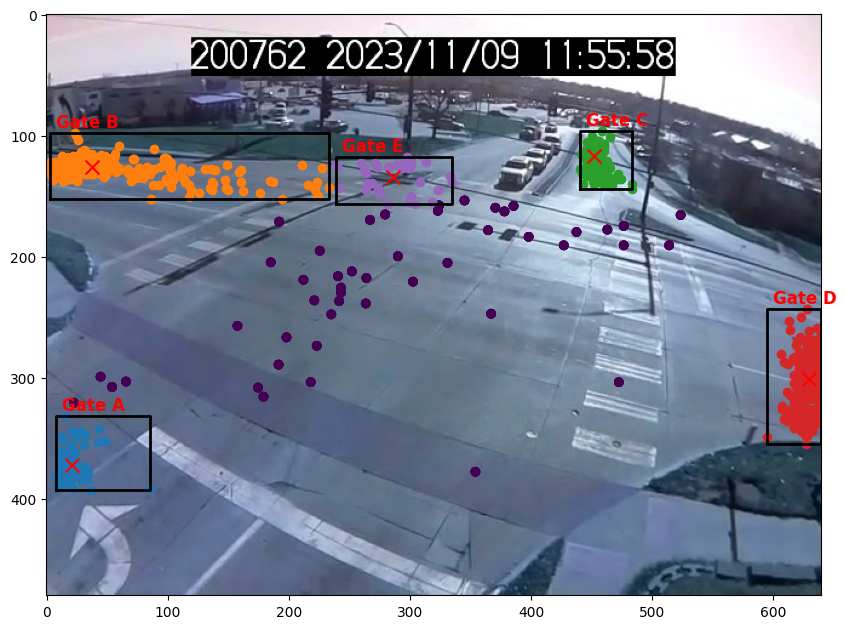

In [60]:
# Copy df_first to avoid modifying the original during iteration
# # Define the OutGate mapping dictionary
# out_gate_mapping = {0: 'W', 1: 'E', 2: 'S', 3: 'E', 4: 'S'}

df_last_clusters = df_last.copy()

# Store updated clusters
updated_clusters = []
fig, ax = plt.subplots(figsize=(10, 8))
for cluster_id, group in df_last_clusters.groupby('Cluster'):
    centroid = (round(float(group['Center_X'].mean()),2), round(float(group['Center_Y'].mean())))
    cluster_count = len(group)
    print(cluster_id, ":", centroid, ":", cluster_count)
    
    # Find the extreme points
    x_min = group.loc[group['Center_X'].idxmin(), 'Center_X']  # Leftmost point
    x_max = group.loc[group['Center_X'].idxmax(), 'Center_X']  # Rightmost point
    y_min = group.loc[group['Center_Y'].idxmin(), 'Center_Y']  # Bottommost point
    y_max = group.loc[group['Center_Y'].idxmax(), 'Center_Y']  # Topmost point


    # Identify outliers that are outside the cluster boundary
    outliers_outside_boundary = df_outlier_last[
        (df_outlier_last['Center_X'] < x_min) | (df_outlier_last['Center_X'] > x_max) |
        (df_outlier_last['Center_Y'] < y_min) | (df_outlier_last['Center_Y'] > y_max)
    ]
    

    # Define rectangle boundary
    rectangle_corners = np.array([
        [x_min, y_max],  # Top-left
        [x_max, y_max],  # Top-right
        [x_max, y_min],  # Bottom-right
        [x_min, y_min],  # Bottom-left
        [x_min, y_max]   # Close the rectangle
    ])

    # Plot the rectangle
    plt.plot(rectangle_corners[:, 0], rectangle_corners[:, 1], 'k-', linewidth=2)

    plt.scatter(df_outlier_last['Center_X'], df_outlier_last['Center_Y'], c = df_outlier_last['Cluster'])

    # Get InGate value using the cluster_id
    out_gate = cluster_to_gate.get(cluster_id, 'Unknown')  # Default to 'Unknown' if cluster_id not in the mapping
    print(cluster_id, out_gate)
    # Append updated cluster data
    updated_clusters.append({
        'OutClusterId': cluster_id,
        'OutGate': out_gate,  # Added InGate value
        'Centroid': centroid,
        'Boundary': (x_min, x_max, y_min, y_max)
    })

    # Plot cluster points
    plt.scatter(group['Center_X'], group['Center_Y'], label=f'Cluster {cluster_id}')

    # Plot gate name near the cluster boundary (placing near top-right corner)
    plt.text(x_min + 5, y_min - 5, f'{out_gate}', fontsize=12, color='red', fontweight='bold')

    # Plot centroid
    plt.scatter(centroid[0], centroid[1], color='red', marker='x', s=100, label=f'Centroid {cluster_id}')

    ax.imshow(cv2.imread(image_path))

OutGateClusters = pd.DataFrame(updated_clusters).sort_values('OutClusterId').reset_index(drop=True)
print(OutGateClusters)

# test = df_sorted.merge(df_last_clusters[df_last_clusters['Cluster'] == 0][['vehicle_id','Cluster']],on='vehicle_id',how='inner')
# print(test['Cluster'].max())
# fig, ax = plt.subplots(figsize=(10, 8))
# ax.imshow(cv2.imread(image_path))
# # Group data by 'vehicle_id' and plot trajectory lines
# for vehicle_id, group in test.groupby('vehicle_id'):
#     # cluster_color = plt.get_cmap("viridis")(group['Cluster'].iloc[0]/test['Cluster'].max())
#     ax.plot(group['Center_X'], group['Center_Y'], c='red')



In [61]:
df_first_clusters = df_first_clusters.rename(columns={'Cluster':'InCluster'})
df_last_clusters = df_last_clusters.rename(columns={'Cluster':'OutCluster'})
print(df_first_clusters.head(2))
df_first_last = df_first_clusters[['vehicle_id','InCluster','InGate']].merge(df_last_clusters[['vehicle_id','OutCluster','OutGate']],on='vehicle_id',how='outer')
print(df_first_last.nunique())

   index  frame  vehicle_id               vehicle_type  Center_X  Center_Y  \
0    116      1           4  cl3_four_tire_single_unit     588.5     206.0   
1    490     16           7          cl2_passenger_car     632.0     237.5   

   Center_X_norm  Center_Y_norm  InCluster  InGate  
0       0.905565       0.152086          0  Gate 1  
1       1.075502       0.564175          0  Gate 1  
vehicle_id    1509
InCluster        6
InGate           6
OutCluster       5
OutGate          5
dtype: int64


In [62]:
print(df_first_last[df_first_last['InCluster'].isnull()].shape)
print(df_first_last[df_first_last['OutCluster'].isnull()].shape)
print(df_first_last[(df_first_last['OutCluster'].isnull())&(df_first_last['InCluster'].isnull())].shape)
print(df_first_last[(df_first_last['OutCluster'].notnull())&(df_first_last['InCluster'].notnull())].shape)

(64, 5)
(45, 5)
(0, 5)
(1400, 5)


In [63]:
# df_ingate_null = df_first_last[df_first_last['InCluster'].isnull()].merge(df_first_frame[['vehicle_id','Center_X','Center_Y']],on='vehicle_id',how='left')

# # Convert centroids to NumPy array
# centroids = np.array([cluster.Centroid for cluster in InGateClusters.itertuples()])
# df_points = df_ingate_null[['Center_X', 'Center_Y']].values

# # Find closest centroid index and distance
# indices, distances = pairwise_distances_argmin_min(df_points, centroids)

# # Assign the closest cluster and distance
# df_ingate_null['InCluster'] = [InGateClusters.iloc[i].InClusterId for i in indices]
# df_ingate_null['InGate'] = [InGateClusters.iloc[i].InGate for i in indices]
# df_ingate_null['Min_Distance'] = distances

df_first_last = df_first_last.merge(df_first_frame[['vehicle_id', 'Center_X', 'Center_Y']], 
                                        on='vehicle_id', how='left')
ingate_updated_rows = pd.DataFrame()
# Identify rows where InCluster is null
mask = df_first_last['InCluster'].isnull()
# Convert centroids to NumPy array
centroids = np.array([cluster.Centroid for cluster in InGateClusters.itertuples()])
df_points = df_first_last.loc[mask, ['Center_X', 'Center_Y']].values

if len(df_points) > 0:
    # Find closest centroid index and distance
    indices, distances = pairwise_distances_argmin_min(df_points, centroids)
    
    # Update df_first_last in place
    df_first_last.loc[mask, 'InCluster'] = [InGateClusters.iloc[i].InClusterId for i in indices]
    df_first_last.loc[mask, 'InGate'] = [InGateClusters.iloc[i].InGate for i in indices]
    # df_first_last.loc[mask, 'Min_Distance'] = distances

# if len(df_points) > 0:
#     # Find closest centroid index and distance
#     indices, distances = pairwise_distances_argmin_min(df_points, centroids)
#     # Filter out points that are further than 200 from their nearest cluster
#     valid_indices = distances <= 100
#     # Get the indices where valid_indices is True
#     valid_indices_positions = np.where(valid_indices)[0]
#     print(valid_indices_positions)
#     if len(valid_indices_positions) > 0:  # Proceed only if there are valid points
#         # Make sure to apply the mask & valid_indices correctly
#         valid_mask = np.zeros(len(df_first_last), dtype=bool)
#         # Mark positions corresponding to valid indices as True in the valid_mask
#         valid_mask[valid_indices_positions] = True
#         print(valid_mask)
#         # Update df_first_last in place
#         df_first_last.loc[valid_mask, 'InCluster'] = [InGateClusters.iloc[i].InClusterId for i in indices[valid_indices_positions]]
#         df_first_last.loc[valid_mask, 'InGate'] = [InGateClusters.iloc[i].InGate for i in indices[valid_indices_positions]]
#         # df_first_last.loc[mask, 'Min_Distance'] = distances

else:
    print("No rows to update.")
    
# Drop 'Center_X' and 'Center_Y' after updating
df_first_last.drop(columns=['Center_X', 'Center_Y'], inplace=True, errors='ignore')
# print(df_first_last[mask])

# Print only the rows that were updated
ingate_updated_rows = df_first_last.loc[mask]
print(ingate_updated_rows.shape)




(64, 5)


In [64]:
# df_ingate_null = df_ingate_null.merge(
#     OutGateClusters[['OutClusterId', 'OutGate']], 
#     how='left', 
#     left_on='OutCluster', 
#     right_on='OutClusterId'
# )

# # Merge with InGateClusters to get InGate
# df_ingate_null = df_ingate_null.merge(
#     InGateClusters[['InClusterId', 'InGate']], 
#     how='left', 
#     left_on='InCluster', 
#     right_on='InClusterId'
# )

if not ingate_updated_rows.empty:
    # Display the updated df_ingate_null dataframe
    print((ingate_updated_rows[['InCluster','InGate','OutCluster','OutGate']].value_counts().reset_index()))
# print((df_ingate_null[(df_ingate_null['InCluster'] == 2) & (df_ingate_null['OutCluster'] == 2)][['InCluster','OutCluster','Center_X','Center_Y']]))

    InCluster  InGate  OutCluster OutGate  count
0         3.0  Gate 4         1.0  Gate B     16
1         5.0  Gate 6         2.0  Gate C     15
2         4.0  Gate 5         2.0  Gate C      8
3         4.0  Gate 5         1.0  Gate B      8
4         5.0  Gate 6         3.0  Gate D      4
5         3.0  Gate 4         3.0  Gate D      4
6         0.0  Gate 1         3.0  Gate D      3
7         4.0  Gate 5         3.0  Gate D      3
8         0.0  Gate 1         0.0  Gate A      1
9         0.0  Gate 1         1.0  Gate B      1
10        3.0  Gate 4         0.0  Gate A      1


C:\Users\ancha\AppData\Local\Temp\ipykernel_15812\2545409617.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))


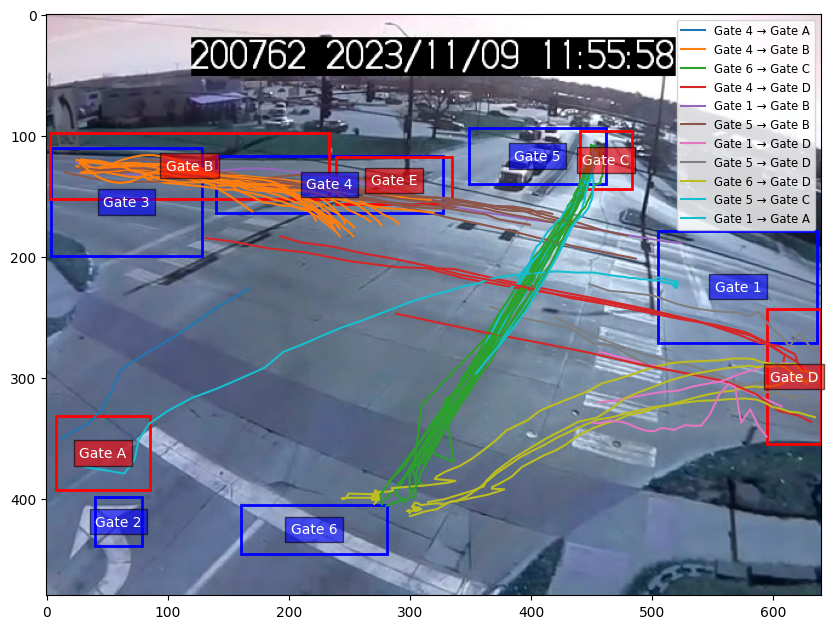

In [65]:
# Initialize a dictionary to store legend handles
legend_handles = {}

if not ingate_updated_rows.empty:
    # Merge df_ingate_null with InGateClusters to get OutGate
    df = df_sorted.merge(ingate_updated_rows[['vehicle_id','InCluster','OutCluster','InGate','OutGate']],on='vehicle_id',how='inner')
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(cv2.imread(image_path))
    # Get unique ('InGate', 'OutGate') pairs
    unique_clusters = df[['InGate', 'OutGate']].drop_duplicates()
    unique_clusters = [tuple(x) for x in unique_clusters.to_numpy()]  # Convert to list of tuples

    # Create a colormap
    cmap = cm.get_cmap('tab10', len(unique_clusters))

    # Create a mapping from ('InGate', 'OutGate') to a color
    color_mapping = {cluster_pair: cmap(i / len(unique_clusters)) for i, cluster_pair in enumerate(unique_clusters)}



# # Plot InGate locations with labels
# for _, row in InGateClusters.iterrows():
#     centroid_x, centroid_y = row['Centroid']
#     ax.scatter(centroid_x, centroid_y, color='blue', marker='o', s=100, label=row['InGate'])
#     ax.text(centroid_x, centroid_y, row['InGate'], fontsize=10, ha='center', va='center', color='white', bbox=dict(facecolor='blue', alpha=0.6, edgecolor='black'))

# # Plot OutGate locations with labels
# for _, row in OutGateClusters.iterrows():
#     centroid_x, centroid_y = row['Centroid']
#     ax.scatter(centroid_x, centroid_y, color='red', marker='o', s=100, label=row['OutGate'])
#     ax.text(centroid_x, centroid_y, row['OutGate'], fontsize=10, ha='center', va='center', color='white', bbox=dict(facecolor='red', alpha=0.6, edgecolor='black'))

    # Plot InGate bounding boxes with labels
    for _, row in InGateClusters.iterrows():
        x_min, x_max, y_min, y_max = row['Boundary']
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
        ax.text((x_min + x_max) / 2, (y_min + y_max) / 2, row['InGate'], fontsize=10, ha='center', va='center', 
                color='white', bbox=dict(facecolor='blue', alpha=0.6, edgecolor='black'))

    # Plot OutGate bounding boxes with labels
    for _, row in OutGateClusters.iterrows():
        x_min, x_max, y_min, y_max = row['Boundary']
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text((x_min + x_max) / 2, (y_min + y_max) / 2, row['OutGate'], fontsize=10, ha='center', va='center', 
                color='white', bbox=dict(facecolor='red', alpha=0.6, edgecolor='black'))
        

    # Group data by 'vehicle_id' and plot trajectory lines
    for vehicle_id, group in df.groupby('vehicle_id'):
        # Extract the unique ('InGate', 'OutGate') pair for this vehicle
        cluster_pair = (group['InGate'].iloc[0], group['OutGate'].iloc[0])

        # Get the corresponding color
        color = color_mapping.get(cluster_pair, 'black')  # Default to black if not found

        ax.plot(group['Center_X'], group['Center_Y'], color = color, label=f'{cluster_pair[0]} → {cluster_pair[1]}')
        # Store legend entry only once per unique cluster pair
        if cluster_pair not in legend_handles:
            legend_handles[cluster_pair] = mlines.Line2D([], [], color=color, label=f'{cluster_pair[0]} → {cluster_pair[1]}')

    # Add legend with correct color mapping
    ax.legend(handles=legend_handles.values(), loc='best', fontsize='small', markerscale=0.5)

    # Optional: Add legend to show cluster pairs
    # ax.legend([f'Cluster {pair[0]} → {pair[1]}' for pair in unique_clusters], loc='best', fontsize='small', markerscale=0.5)


In [66]:
df_first_last = df_first_last.merge(df_last_frame[['vehicle_id', 'Center_X', 'Center_Y']], 
                                        on='vehicle_id', how='left')
outgate_updated_rows = pd.DataFrame()

# Identify rows where OutCluster is null
mask = df_first_last['OutCluster'].isnull()
# Convert centroids to NumPy array
centroids = np.array([cluster.Centroid for cluster in OutGateClusters.itertuples()])
df_points = df_first_last.loc[mask, ['Center_X', 'Center_Y']].values

if len(df_points) > 0:
    # Find closest centroid index and distance
    indices, distances = pairwise_distances_argmin_min(df_points, centroids)
    
    # Update df_first_last in place
    df_first_last.loc[mask, 'OutCluster'] = [OutGateClusters.iloc[i].OutClusterId for i in indices]
    df_first_last.loc[mask, 'OutGate'] = [OutGateClusters.iloc[i].OutGate for i in indices]
    # df_first_last.loc[mask, 'Min_Distance'] = distances
    

else:
    print("No rows to update.")

# Drop 'Center_X' and 'Center_Y' after updating
df_first_last.drop(columns=['Center_X', 'Center_Y'], inplace=True, errors='ignore')
# print(df_first_last[mask])

# Print only the rows that were updated
outgate_updated_rows = df_first_last.loc[mask]
print(outgate_updated_rows.shape)

(45, 5)


In [67]:
# df_outgate_null = df_outgate_null.merge(
#     OutGateClusters[['OutClusterId', 'OutGate']], 
#     how='left', 
#     left_on='OutCluster', 
#     right_on='OutClusterId'
# )

# # Merge with InGateClusters to get InGate
# df_outgate_null = df_outgate_null.merge(
#     InGateClusters[['InClusterId', 'InGate']], 
#     how='left', 
#     left_on='InCluster', 
#     right_on='InClusterId'
# )
if not outgate_updated_rows.empty:
    # Display the updated df_ingate_null dataframe
    print((outgate_updated_rows[['InCluster','InGate','OutCluster','OutGate']].value_counts().reset_index()))
# print((df_outgate_null[(df_outgate_null['InCluster'] == 2) & (df_outgate_null['OutCluster'] == 2)][['InCluster','OutCluster','Center_X','Center_Y']]))

    InCluster  InGate  OutCluster OutGate  count
0         1.0  Gate 2         4.0  Gate E     15
1         0.0  Gate 1         2.0  Gate C      9
2         0.0  Gate 1         4.0  Gate E      7
3         2.0  Gate 3         4.0  Gate E      5
4         4.0  Gate 5         0.0  Gate A      3
5         0.0  Gate 1         0.0  Gate A      1
6         1.0  Gate 2         0.0  Gate A      1
7         2.0  Gate 3         3.0  Gate D      1
8         1.0  Gate 2         1.0  Gate B      1
9         5.0  Gate 6         2.0  Gate C      1
10        5.0  Gate 6         4.0  Gate E      1


C:\Users\ancha\AppData\Local\Temp\ipykernel_15812\2815054608.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))


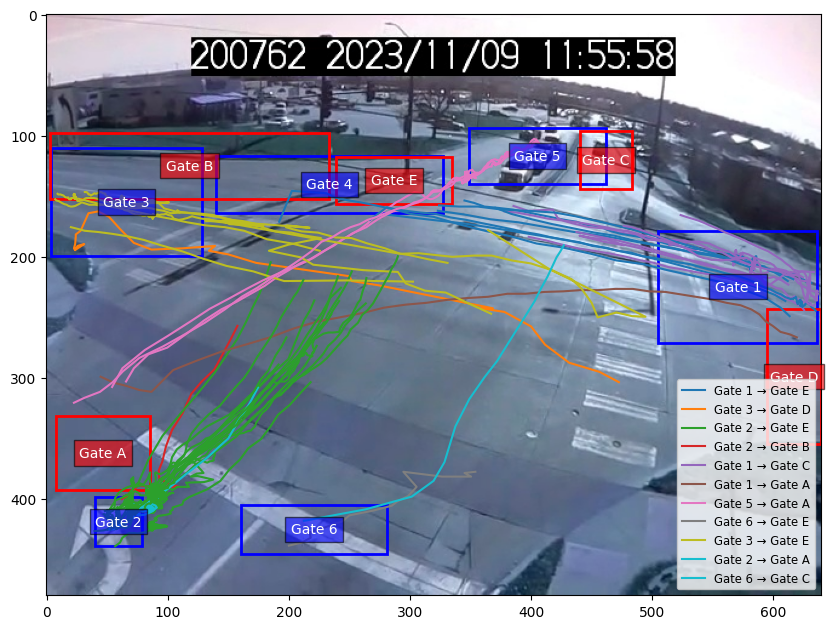

In [68]:
import matplotlib.lines as mlines

# Initialize a dictionary to store legend handles
legend_handles = {}
if not ingate_updated_rows.empty:

    # Merge df_outgate_null with OutGateClusters to get OutGate
    df = df_sorted.merge(outgate_updated_rows[['vehicle_id','InCluster','OutCluster','InGate','OutGate']],on='vehicle_id',how='inner')
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(cv2.imread(image_path))
    # Get unique ('InGate', 'OutGate') pairs
    unique_clusters = df[['InGate', 'OutGate']].drop_duplicates()
    unique_clusters = [tuple(x) for x in unique_clusters.to_numpy()]  # Convert to list of tuples

    # Create a colormap
    cmap = cm.get_cmap('tab10', len(unique_clusters))

    # Create a mapping from ('InGate', 'OutGate') to a color
    color_mapping = {cluster_pair: cmap(i / len(unique_clusters)) for i, cluster_pair in enumerate(unique_clusters)}


    # Plot InGate bounding boxes with labels
    for _, row in InGateClusters.iterrows():
        x_min, x_max, y_min, y_max = row['Boundary']
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
        ax.text((x_min + x_max) / 2, (y_min + y_max) / 2, row['InGate'], fontsize=10, ha='center', va='center', 
                color='white', bbox=dict(facecolor='blue', alpha=0.6, edgecolor='black'))

    # Plot OutGate bounding boxes with labels
    for _, row in OutGateClusters.iterrows():
        x_min, x_max, y_min, y_max = row['Boundary']
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text((x_min + x_max) / 2, (y_min + y_max) / 2, row['OutGate'], fontsize=10, ha='center', va='center', 
                color='white', bbox=dict(facecolor='red', alpha=0.6, edgecolor='black'))
        
    # Group data by 'vehicle_id' and plot trajectory lines
    for vehicle_id, group in df.groupby('vehicle_id'):
        # Extract the unique ('InGate', 'OutGate') pair for this vehicle
        cluster_pair = (group['InGate'].iloc[0], group['OutGate'].iloc[0])

        # Get the corresponding color
        color = color_mapping.get(cluster_pair, 'black')  # Default to black if not found

        ax.plot(group['Center_X'], group['Center_Y'], color = color, label=f'{cluster_pair[0]} → {cluster_pair[1]}')
        # Store legend entry only once per unique cluster pair
        if cluster_pair not in legend_handles:
            legend_handles[cluster_pair] = mlines.Line2D([], [], color=color, label=f'{cluster_pair[0]} → {cluster_pair[1]}')

    # Add legend with correct color mapping
    ax.legend(handles=legend_handles.values(), loc='best', fontsize='small', markerscale=0.5)

# Optional: Add legend to show cluster pairs
# ax.legend([f'Cluster {pair[0]} → {pair[1]}' for pair in unique_clusters], loc='best', fontsize='small', markerscale=0.5)


C:\Users\ancha\AppData\Local\Temp\ipykernel_15812\3445287818.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_clusters))


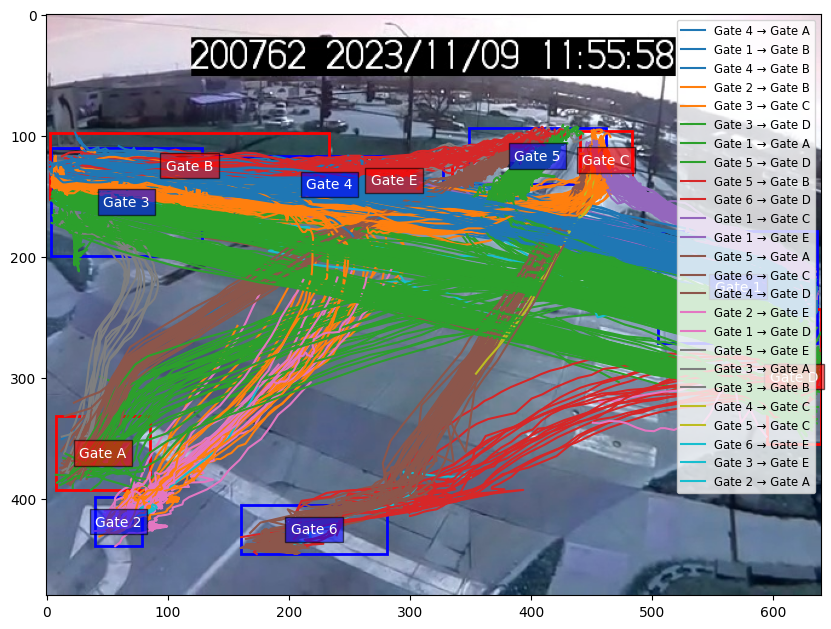

In [69]:
import matplotlib.lines as mlines

# Initialize a dictionary to store legend handles
legend_handles = {}


# Merge df_outgate_null with OutGateClusters to get OutGate
df = df_sorted.merge(df_first_last[(df_first_last['InGate'].notna()) & (df_first_last['OutGate'].notna())][['vehicle_id','InCluster','OutCluster','InGate','OutGate']],on='vehicle_id',how='inner')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cv2.imread(image_path))
# Get unique ('InGate', 'OutGate') pairs
unique_clusters = df[['InGate', 'OutGate']].drop_duplicates()
unique_clusters = [tuple(x) for x in unique_clusters.to_numpy()]  # Convert to list of tuples

# Create a colormap
cmap = cm.get_cmap('tab10', len(unique_clusters))

# Create a mapping from ('InGate', 'OutGate') to a color
color_mapping = {cluster_pair: cmap(i / len(unique_clusters)) for i, cluster_pair in enumerate(unique_clusters)}


# Plot InGate bounding boxes with labels
for _, row in InGateClusters.iterrows():
    x_min, x_max, y_min, y_max = row['Boundary']
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
    ax.text((x_min + x_max) / 2, (y_min + y_max) / 2, row['InGate'], fontsize=10, ha='center', va='center', 
            color='white', bbox=dict(facecolor='blue', alpha=0.6, edgecolor='black'))

# Plot OutGate bounding boxes with labels
for _, row in OutGateClusters.iterrows():
    x_min, x_max, y_min, y_max = row['Boundary']
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text((x_min + x_max) / 2, (y_min + y_max) / 2, row['OutGate'], fontsize=10, ha='center', va='center', 
            color='white', bbox=dict(facecolor='red', alpha=0.6, edgecolor='black'))
    
# Group data by 'vehicle_id' and plot trajectory lines
for vehicle_id, group in df.groupby('vehicle_id'):
    # Extract the unique ('InGate', 'OutGate') pair for this vehicle
    cluster_pair = (group['InGate'].iloc[0], group['OutGate'].iloc[0])

    # Get the corresponding color
    color = color_mapping.get(cluster_pair, 'black')  # Default to black if not found

    ax.plot(group['Center_X'], group['Center_Y'], color = color, label=f'{cluster_pair[0]} → {cluster_pair[1]}')
    # Store legend entry only once per unique cluster pair
    if cluster_pair not in legend_handles:
        legend_handles[cluster_pair] = mlines.Line2D([], [], color=color, label=f'{cluster_pair[0]} → {cluster_pair[1]}')

# Add legend with correct color mapping
ax.legend(handles=legend_handles.values(), loc='best', fontsize='small', markerscale=0.5)

# Optional: Add legend to show cluster pairs
# ax.legend([f'Cluster {pair[0]} → {pair[1]}' for pair in unique_clusters], loc='best', fontsize='small', markerscale=0.5)


In [70]:
# merges each vehicle's first frame cluster ID into df_sorted, ensuring consistent cluster IDs for all vehicle occurrences.
final_df = df_sorted.merge(df_first_last[['vehicle_id','InCluster','InGate','OutCluster','OutGate']],on='vehicle_id',how='inner')

print(final_df)

        frame  vehicle_id       vehicle_type  Center_X  Center_Y  dx  dy  \
0           1           2  cl2_passenger_car     167.5     225.5 NaN NaN   
1           2           2  cl2_passenger_car     156.0     233.0 NaN NaN   
2           3           2  cl2_passenger_car     140.0     242.0 NaN NaN   
3           4           2  cl2_passenger_car     124.0     253.5 NaN NaN   
4           5           2  cl2_passenger_car     107.0     265.0 NaN NaN   
...       ...         ...                ...       ...       ...  ..  ..   
174089  35995        2947  cl2_passenger_car     413.5     216.5 NaN NaN   
174090  35996        2947  cl2_passenger_car     417.5     208.0 NaN NaN   
174091  35997        2947  cl2_passenger_car     421.0     200.5 NaN NaN   
174092  35998        2947  cl2_passenger_car     424.5     195.0 NaN NaN   
174093  35999        2947  cl2_passenger_car     427.0     190.5 NaN NaN   

        InCluster  InGate  OutCluster OutGate  
0             3.0  Gate 4         0.0  

In [71]:
# Store results
vehicle_data_result = []

for vehicle_id, vehicle_traj_group in final_df.groupby('vehicle_id'):
        
    # Store result
    vehicle_data_result.append({
        'Vehicle ID': vehicle_id, 
        'Class': vehicle_traj_group.iloc[0]['vehicle_type'],
        'Start Frame': vehicle_traj_group.iloc[0]['frame'],
        'End Frame': vehicle_traj_group.iloc[-1]['frame'],
        'InCluster': vehicle_traj_group.iloc[0]['InCluster'],
        'InGate': vehicle_traj_group.iloc[0]['InGate'],
        'OutCluster': vehicle_traj_group.iloc[0]['OutCluster'],
        'OutGate': vehicle_traj_group.iloc[0]['OutGate']
        })
        

# Convert to DataFrame if needed
output = pd.DataFrame(vehicle_data_result).sort_values(by='Vehicle ID').reset_index(drop=True)
print(output.shape)

(1509, 8)


In [72]:
output['Counted'] = np.where(output['InGate'] == output['OutGate'], '', 'Y')
new_column_order = ['Vehicle ID','Class','Start Frame','End Frame','Counted','InCluster','InGate','OutCluster','OutGate']
output = output[new_column_order]
print(output.nunique())

print(output[['InGate','OutGate']].value_counts().reset_index())
# output.to_csv("../output_40_1.csv",index=False)

Vehicle ID     1509
Class             8
Start Frame    1482
End Frame      1479
Counted           1
InCluster         6
InGate            6
OutCluster        5
OutGate           5
dtype: int64
    InGate OutGate  count
0   Gate 1  Gate B    420
1   Gate 3  Gate D    287
2   Gate 1  Gate C    142
3   Gate 3  Gate C    127
4   Gate 5  Gate D    110
5   Gate 4  Gate B     90
6   Gate 5  Gate B     85
7   Gate 6  Gate C     44
8   Gate 1  Gate A     35
9   Gate 5  Gate A     35
10  Gate 1  Gate E     23
11  Gate 2  Gate B     21
12  Gate 5  Gate E     19
13  Gate 6  Gate D     18
14  Gate 2  Gate E     15
15  Gate 3  Gate A     11
16  Gate 5  Gate C      8
17  Gate 3  Gate E      5
18  Gate 4  Gate D      4
19  Gate 1  Gate D      3
20  Gate 3  Gate B      2
21  Gate 4  Gate C      2
22  Gate 2  Gate A      1
23  Gate 4  Gate A      1
24  Gate 6  Gate E      1
